In [1]:
!pip install optuna scikit-learn seaborn scipy --quiet

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import mutual_info_classif, f_classif
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from google.colab import drive

# Подключение Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

# Загрузка и подготовка данных
data_path = '/content/drive/MyDrive/data_c/data_fe.csv'
data = pd.read_csv(data_path)
print("Данные загружены, форма:", data.shape)

# Разделяем на train/test
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

# Вычисляем медианы для создания меток
medians = {
    'IC50': train_df['IC50'].median(),
    'CC50': train_df['CC50'].median(),
    'SI': train_df['SI'].median()
}

# Создаем бинарные цели
for df in [data, train_df, test_df]:
    df['IC50_above_median'] = (df['IC50'] > medians['IC50']).astype(int)
    df['CC50_above_median'] = (df['CC50'] > medians['CC50']).astype(int)
    df['SI_above_median'] = (df['SI'] > medians['SI']).astype(int)
    df['SI_above_8'] = (df['SI'] > 8).astype(int)

# Определяем признаки и целевую переменную
features = [c for c in data.columns if c not in [
    'IC50','pIC50','CC50','pCC50','SI','SI_log',
    'IC50_above_median','CC50_above_median','SI_above_median','SI_above_8'
]]
target = 'CC50_above_median'

# Масштабируем признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_df[features])
X_test_scaled = scaler.transform(test_df[features])
y_train = train_df[target]
y_test = test_df[target]


Данные загружены, форма: (998, 167)


In [3]:

# Отбор признаков (top-50)
# Mutual Information
mi_scores = mutual_info_classif(X_train_scaled, y_train)
mi_indices = np.argsort(mi_scores)[::-1][:50]
# F-score
f_scores, _ = f_classif(X_train_scaled, y_train)
f_indices = np.argsort(f_scores)[::-1][:50]


In [4]:

# Оцениваем, какой метод лучше по AUC на train
def eval_indices(indices):
    X_sel = X_train_scaled[:, indices]
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_sel, y_train)
    proba = model.predict_proba(X_sel)[:,1]
    return roc_auc_score(y_train, proba)

mi_auc = eval_indices(mi_indices)
f_auc = eval_indices(f_indices)
if mi_auc >= f_auc:
    selected_idx = mi_indices
    sel_scores = mi_scores
    method = 'mutual_info'
    auc_sel = mi_auc
else:
    selected_idx = f_indices
    sel_scores = f_scores
    method = 'f_classif'
    auc_sel = f_auc

print(f"Выбран метод отбора: {method} (Train AUC={auc_sel:.4f})")
selected_features = [features[i] for i in selected_idx]


Выбран метод отбора: mutual_info (Train AUC=0.8167)


Топ-20 признаков по выбранному методу:
BCUT2D_MWLOW: 0.1914
MinPartialCharge: 0.1861
BCUT2D_MWHI: 0.1808
BCUT2D_CHGLO: 0.1727
MaxPartialCharge: 0.1593
SlogP_VSA2: 0.1585
BCUT2D_MRHI: 0.1468
BCUT2D_LOGPLOW: 0.1459
BCUT2D_LOGPHI: 0.1420
TPSA: 0.1417
BCUT2D_MRLOW: 0.1404
PEOE_VSA1: 0.1292
BCUT2D_CHGHI: 0.1276
AvgIpc: 0.1240
PEOE_VSA8: 0.1169
PEOE_VSA6: 0.1143
SlogP_VSA5: 0.1090
PEOE_VSA9: 0.1080
MinAbsEStateIndex: 0.1076
EState_VSA8: 0.1043


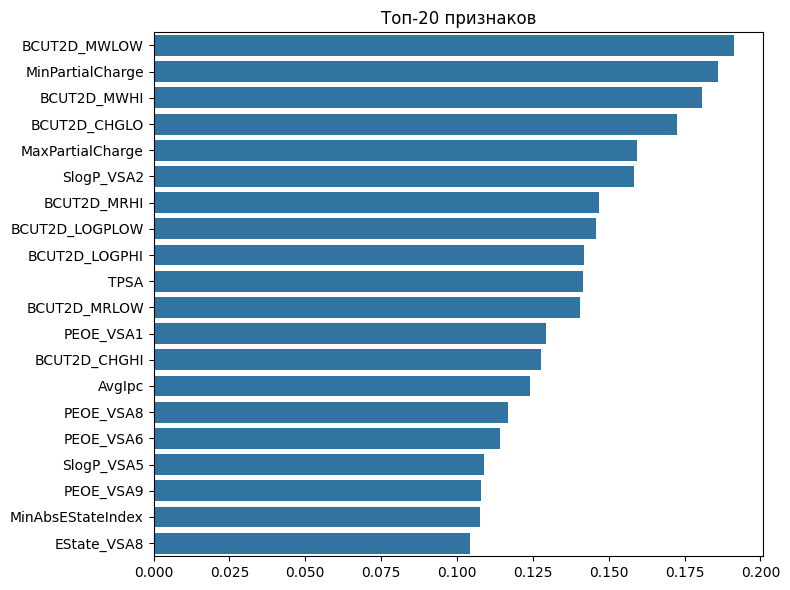

In [5]:

# Топ-20 признаки
top20 = np.argsort(sel_scores)[::-1][:20]
print("Топ-20 признаков по выбранному методу:")
for i in top20:
    print(f"{features[i]}: {sel_scores[i]:.4f}")

# Подготавливаем отобранные данные
X_train_sel = X_train_scaled[:, selected_idx]
X_test_sel = X_test_scaled[:, selected_idx]

# Визуализация топ-20
plt.figure(figsize=(8,6))
sns.barplot(x=sel_scores[top20], y=np.array(features)[top20])
plt.title('Топ-20 признаков')
plt.tight_layout()
plt.show()


In [6]:

# Сравнение базовых моделей
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42)
}

# Сохраняем обученные модели для ансамбля
trained_models = {}
results = {}

for name, m in models.items():
    m.fit(X_train_sel, y_train)
    trained_models[name] = m  # Сохраняем обученную модель

    proba = m.predict_proba(X_test_sel)[:,1]
    auc = roc_auc_score(y_test, proba)
    acc = accuracy_score(y_test, (proba>0.5).astype(int))
    f1 = f1_score(y_test, (proba>0.5).astype(int))
    results[name] = {'AUC':auc, 'Accuracy':acc, 'F1':f1}
    print(f"{name}: AUC={auc:.4f}, Acc={acc:.4f}, F1={f1:.4f}")

# Выбираем лучшую
best_model_name = max(results, key=lambda k: results[k]['AUC'])
print(f"\nЛучшая модель: {best_model_name}")


LogisticRegression: AUC=0.7721, Acc=0.7200, F1=0.7407
RandomForest: AUC=0.8487, Acc=0.7800, F1=0.7864
GradientBoosting: AUC=0.8509, Acc=0.7900, F1=0.8019
SVC: AUC=0.8222, Acc=0.7500, F1=0.7664

Лучшая модель: GradientBoosting


In [7]:

# Оптимизация гиперпараметров (Optuna)
model_classes = {
    'LogisticRegression': LogisticRegression,
    'RandomForest': RandomForestClassifier,
    'GradientBoosting': GradientBoostingClassifier,
    'SVC': SVC
}

BestModelClass = model_classes[best_model_name]

def get_param_func(name):
    if name == 'LogisticRegression':
        return lambda t: {
            'C': t.suggest_float('C', 0.01, 100, log=True),
            'max_iter': 1000,
            'random_state': 42
        }
    if name == 'RandomForest':
        return lambda t: {
            'n_estimators': t.suggest_int('n_estimators', 50, 1000),
            'max_depth': t.suggest_int('max_depth', 3, 50),
            'min_samples_split': t.suggest_int('min_samples_split', 2, 30),
            'min_samples_leaf': t.suggest_int('min_samples_leaf', 1, 20),
            'max_features': t.suggest_categorical('max_features', ['sqrt', 'log2', 0.5, 0.6, 0.7, 0.8, 0.9]),
            'bootstrap': t.suggest_categorical('bootstrap', [True, False]),
            'class_weight': t.suggest_categorical('class_weight', [None, 'balanced']),
            'random_state': 42,
            'n_jobs': -1
        }
    if name == 'GradientBoosting':
        return lambda t: {
            'n_estimators': t.suggest_int('n_estimators', 100, 500),
            'max_depth': t.suggest_int('max_depth', 3, 10),
            'learning_rate': t.suggest_float('learning_rate', 0.01, 0.3,
                                             log=True),
            'subsample': t.suggest_float('subsample', 0.7, 1.0),
            'min_samples_leaf': t.suggest_int('min_samples_leaf', 1, 10),
            'random_state': 42
        }
    if name == 'SVC':
        return lambda t: {
            'C': t.suggest_float('C', 0.1, 10, log=True),
            'gamma': t.suggest_float('gamma', 1e-5, 0.1, log=True),
            'probability': True,
            'random_state': 42
        }
    return None


In [8]:

# Оптимизация гиперпараметров
param_func = get_param_func(best_model_name)
if param_func is not None:
    def objective(trial):
      params = param_func(trial)
      model = BestModelClass(**params)

      # Используем кросс-валидацию с 3 фолдами для скорости
      kf = KFold(n_splits=3, shuffle=True, random_state=42)
      auc_scores = []

      for tr_idx, val_idx in kf.split(X_train_sel):
          X_tr, X_val = X_train_sel[tr_idx], X_train_sel[val_idx]
          y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

          model.fit(X_tr, y_tr)
          proba = model.predict_proba(X_val)[:, 1]
          auc = roc_auc_score(y_val, proba)
          auc_scores.append(auc)

      # Возвращаем 1 - средний AUC
      return 1 - np.mean(auc_scores)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    best_params = study.best_params
    print("Лучшие гиперпараметры:", best_params)

    # Финальная модель с оптимальными параметрами
    optimized_model = BestModelClass(**best_params)
    optimized_model.fit(X_train_sel, y_train)
    trained_models[f'Optimized_{best_model_name}'] = optimized_model

    # Оценка на тестовых данных
    test_proba = optimized_model.predict_proba(X_test_sel)[:, 1]
    test_auc = roc_auc_score(y_test, test_proba)
    test_acc = accuracy_score(y_test, (test_proba > 0.5).astype(int))
    test_f1 = f1_score(y_test, (test_proba > 0.5).astype(int))
    print(f"Оптимизированная модель {best_model_name} (тест AUC): \
    {test_auc:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}")
else:
    optimized_model = BestModelClass()
    optimized_model.fit(X_train_sel, y_train)
    test_proba = optimized_model.predict_proba(X_test_sel)[:, 1]
    test_auc = roc_auc_score(y_test, test_proba)
    test_acc = accuracy_score(y_test, (test_proba > 0.5).astype(int))
    test_f1 = f1_score(y_test, (test_proba > 0.5).astype(int))
    print(f"Базовая модель {best_model_name} (тест AUC): \
    {test_auc:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}")


[I 2025-06-18 08:48:55,630] A new study created in memory with name: no-name-224bbebd-941a-4fcb-910c-7e08f8658ccd
[I 2025-06-18 08:49:24,495] Trial 0 finished with value: 0.19531463619245348 and parameters: {'n_estimators': 391, 'max_depth': 6, 'learning_rate': 0.12685587508293586, 'subsample': 0.7763397734564417, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.19531463619245348.
[I 2025-06-18 08:49:32,090] Trial 1 finished with value: 0.1774419987478778 and parameters: {'n_estimators': 328, 'max_depth': 3, 'learning_rate': 0.05537883680855252, 'subsample': 0.7243377066494593, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.1774419987478778.
[I 2025-06-18 08:50:01,861] Trial 2 finished with value: 0.17991244270929274 and parameters: {'n_estimators': 490, 'max_depth': 8, 'learning_rate': 0.011398626954953583, 'subsample': 0.9445915894695046, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.1774419987478778.
[I 2025-06-18 08:50:09,019] Trial 3 finished with value: 0.1825

Лучшие гиперпараметры: {'n_estimators': 131, 'max_depth': 6, 'learning_rate': 0.022788241992113226, 'subsample': 0.709439551070775, 'min_samples_leaf': 10}
Оптимизированная модель GradientBoosting (тест AUC):     0.8511, Acc: 0.7800, F1: 0.7925


In [9]:

# Ансамблирование моделей
print("\nСоздание ансамблей моделей...")

# 1. Voting Classifier (мягкое голосование по вероятностям)
voting_models = [
    ('lr', trained_models['LogisticRegression']),
    ('rf', trained_models['RandomForest']),
    ('gb', trained_models['GradientBoosting']),
    ('svc', trained_models['SVC'])
]

voting_clf = VotingClassifier(
    estimators=voting_models,
    voting='soft',  # Голосование по вероятностям
    n_jobs=-1
)
voting_clf.fit(X_train_sel, y_train)
voting_proba = voting_clf.predict_proba(X_test_sel)[:, 1]
voting_auc = roc_auc_score(y_test, voting_proba)
voting_acc = accuracy_score(y_test, (voting_proba > 0.5).astype(int))
voting_f1 = f1_score(y_test, (voting_proba > 0.5).astype(int))
print(f"Voting Classifier: AUC={voting_auc:.4f}, \
Acc={voting_acc:.4f}, F1={voting_f1:.4f}")



Создание ансамблей моделей...
Voting Classifier: AUC=0.8480, Acc=0.7700, F1=0.7830


In [10]:

# 2. Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=voting_models,
    final_estimator=LogisticRegression(max_iter=1000, C=0.1),
    cv=5,
    n_jobs=-1
)
stacking_clf.fit(X_train_sel, y_train)
stacking_proba = stacking_clf.predict_proba(X_test_sel)[:, 1]
stacking_auc = roc_auc_score(y_test, stacking_proba)
stacking_acc = accuracy_score(y_test, (stacking_proba > 0.5).astype(int))
stacking_f1 = f1_score(y_test, (stacking_proba > 0.5).astype(int))
print(f"Stacking Classifier: AUC={stacking_auc:.4f}, \
Acc={stacking_acc:.4f}, F1={stacking_f1:.4f}")


Stacking Classifier: AUC=0.8508, Acc=0.7700, F1=0.7830


In [11]:

# 3. Bagging оптимизированной модели
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(
    estimator=optimized_model if 'optimized_model' in locals() else trained_models[best_model_name],
    n_estimators=20,
    max_samples=0.8,
    max_features=0.8,
    random_state=42,
    n_jobs=-1
)
bagging_clf.fit(X_train_sel, y_train)
bagging_proba = bagging_clf.predict_proba(X_test_sel)[:, 1]
bagging_auc = roc_auc_score(y_test, bagging_proba)
bagging_acc = accuracy_score(y_test, (bagging_proba > 0.5).astype(int))
bagging_f1 = f1_score(y_test, (bagging_proba > 0.5).astype(int))
print(f"Bagging Classifier: AUC={bagging_auc:.4f}, \
Acc={bagging_acc:.4f}, F1={bagging_f1:.4f}")


Bagging Classifier: AUC=0.8291, Acc=0.7600, F1=0.7736


In [12]:

# Сравнение всех методов
methods = {
    'Best Base Model': results[best_model_name],
    'Optimized Model': {'AUC': test_auc, 'Accuracy': test_acc, 'F1': test_f1},
    'Voting': {'AUC': voting_auc, 'Accuracy': voting_acc, 'F1': voting_f1},
    'Stacking': {'AUC': stacking_auc, 'Accuracy': stacking_acc, 'F1': stacking_f1},
    'Bagging': {'AUC': bagging_auc, 'Accuracy': bagging_acc, 'F1': bagging_f1}
}


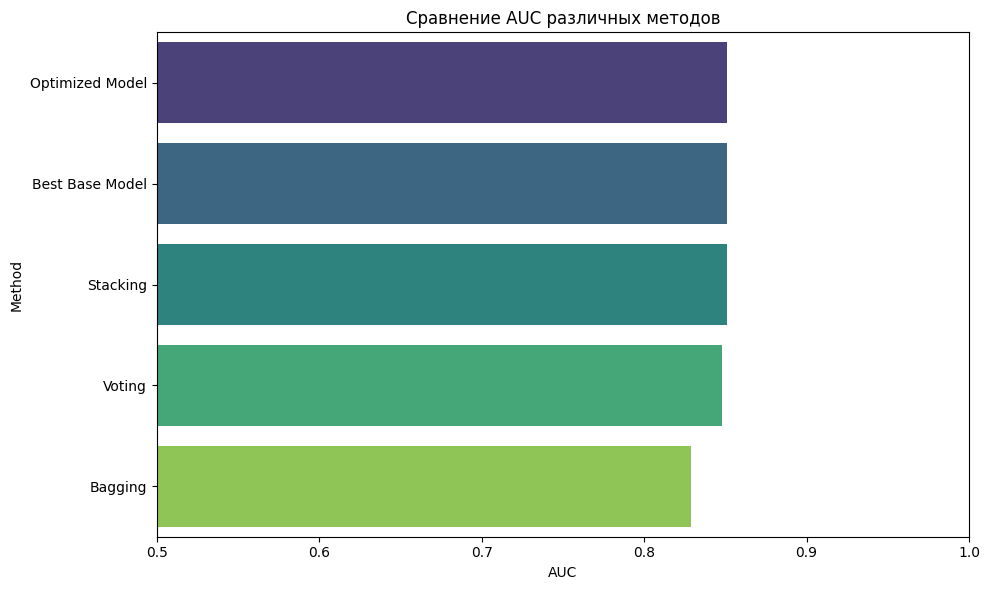

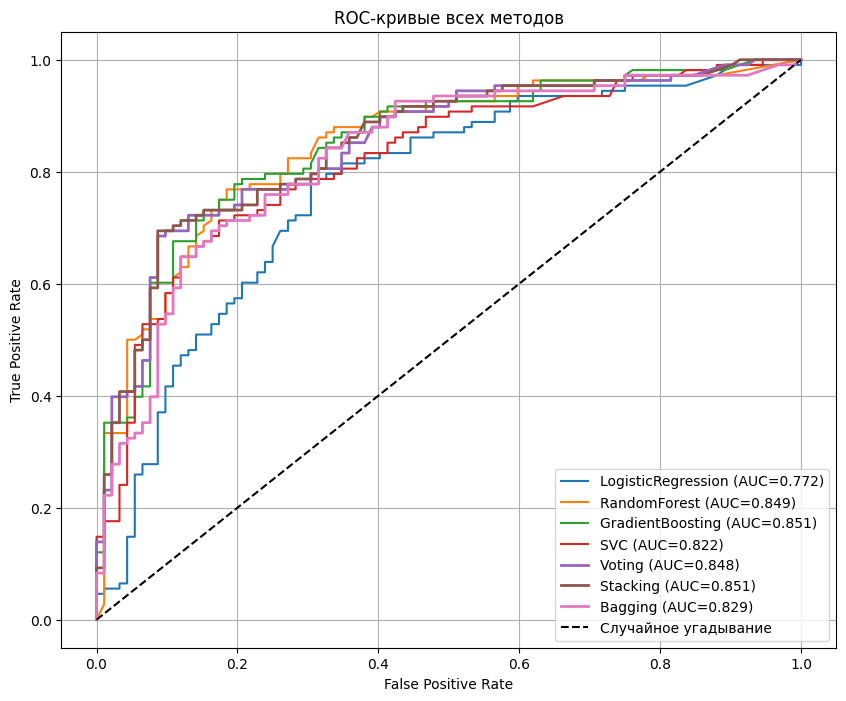

In [13]:

# Визуализация сравнения AUC
auc_comparison = pd.DataFrame({
    'Method': list(methods.keys()),
    'AUC': [methods[m]['AUC'] for m in methods]
}).sort_values('AUC', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='AUC', y='Method', data=auc_comparison, palette='viridis')
plt.title('Сравнение AUC различных методов')
plt.xlim(0.5, 1.0)
plt.tight_layout()
plt.show()

# ROC-кривые для всех методов
plt.figure(figsize=(10, 8))

# ROC для базовых моделей
for name, model in models.items():
    proba = model.predict_proba(X_test_sel)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={results[name]["AUC"]:.3f})')


# ROC для ансамблей
fpr_voting, tpr_voting, _ = roc_curve(y_test, voting_proba)
plt.plot(fpr_voting, tpr_voting, label=f'Voting (AUC={voting_auc:.3f})',
         linewidth=2)

fpr_stacking, tpr_stacking, _ = roc_curve(y_test, stacking_proba)
plt.plot(fpr_stacking, tpr_stacking, label=f'Stacking (AUC={stacking_auc:.3f})',
         linewidth=2)

fpr_bagging, tpr_bagging, _ = roc_curve(y_test, bagging_proba)
plt.plot(fpr_bagging, tpr_bagging, label=f'Bagging (AUC={bagging_auc:.3f})',
         linewidth=2)

# Диагональ
plt.plot([0, 1], [0, 1], 'k--', label='Случайное угадывание')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые всех методов')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


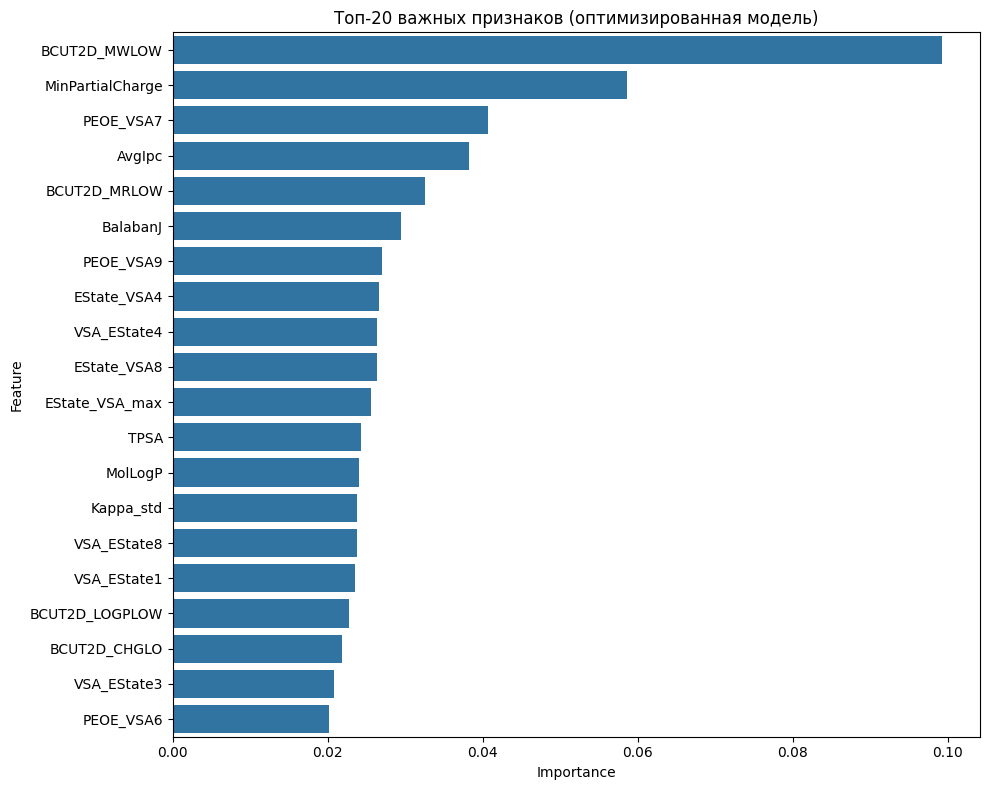

In [14]:

# Анализ важности признаков для лучшей модели
if hasattr(optimized_model, 'feature_importances_'):
    importances = optimized_model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Топ-20 важных признаков (оптимизированная модель)')
    plt.tight_layout()
    plt.show()
elif hasattr(optimized_model, 'coef_'):
    coefs = optimized_model.coef_[0]
    coef_df = pd.DataFrame({
        'Feature': selected_features,
        'Coefficient': coefs
    }).sort_values('Coefficient', ascending=False)

    # Топ-10 положительных и отрицательных
    top_coef = pd.concat([coef_df.head(10), coef_df.tail(10)])

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Coefficient', y='Feature', data=top_coef)
    plt.title('Важные признаки по коэффициентам')
    plt.tight_layout()
    plt.show()